In [137]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import string
from torch.utils.data import random_split, TensorDataset
#from xgboost import XGBClassifier

In [138]:
data = pd.read_csv("Stress.csv")

In [139]:
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [141]:
data.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [142]:
#Realizaremos una wordcloud para analizar la frecuencia de las palabras

In [143]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iangarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
def clean(text):
    """
    Normalize text column
    """
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [145]:
data["text"] = data["text"].apply(clean)

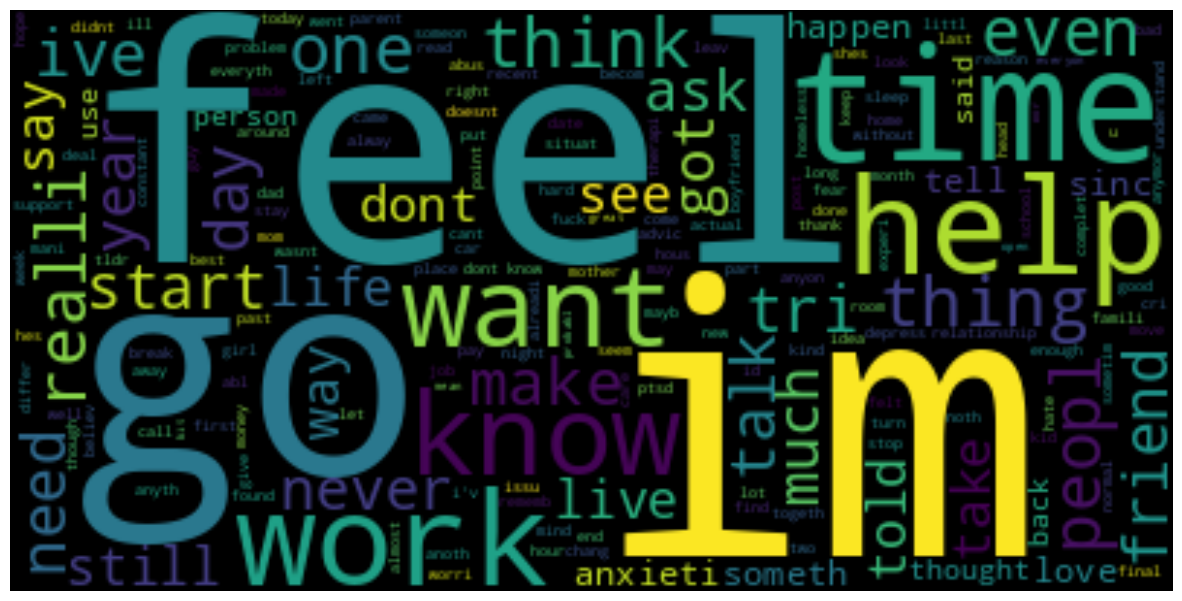

In [146]:
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [147]:
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)",said felt way sugget go rest trigger ahead you...,1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)",hey rassist sure right place post goe im curr...,0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",mom hit newspap shock would know dont like pla...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]",met new boyfriend amaz kind sweet good student...,1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",octob domest violenc awar month domest violenc...,1,0.8,1539809005


In [148]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # más uno para marcar el final.
def unicodeToAscii(s):
    '''
    Función auxiliar para transformae elementos de UNICODE a ASCII
    '''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
def normalizeLines(lines):
    return [int.from_bytes(unicodeToAscii(line).encode()) for line in lines]

In [149]:
data = pd.read_csv("Stress.csv")
print(data.shape[0])


"""
Para esta primer versión utilizaremos el fragmento de texto y su relación
binaria de estrés o no estrés
FYI: Espero tener el suficiente tiempo para implementar una version que recoja mas datos
y realizar una comparativa entre ambas

---
Cambio
---
Es posible que sea necesario utilizar más datos para mejorar el aprendizaje
---
Convertimos un fragmento seleccionado al azar compuesto por un fragmento pequeno
previamente mostrado en el sentence range.
"""
import sys
sys.set_int_max_str_digits(0)#increase limit of digits for calcs

datay=data[data.columns[4]]#Columna con label (0,1) estres o no estres
datax=data.drop(columns=["label", "post_id", "sentence_range", "social_timestamp"]) #Columna con datos de salida
#datax.head()
sentence_range_list=list(data["sentence_range"])
subreddit_list=list(datax["subreddit"])
text_list=list(datax["text"])
confidence_list=list(datax["confidence"])

text_unicode=[]
#transformando a ascii
filas=0
for t,m in zip(text_list,sentence_range_list):
    m=m[1:-1]
    x1,x2= tuple(map(int, m.split(', ')))
    minilist_words=t.strip()[x1:x2]
    int_text=normalizeLines(unicodeToAscii(minilist_words.strip()))
    #print(int_text)
    big_str=''
    limit=0
    for i in int_text:
        big_str+=str(i)
        limit+=1
        if big_str=='':
            continue
    try:
        text_unicode.append(int(big_str))
    except ValueError:
        continue
filas+=1

datax = pd.DataFrame(list(zip(text_unicode, subreddit_list, confidence_list)))
datax.head()

2838


,0,1,2
0,11011111632102,ptsd,0.8
1,7210112132116,assistance,1.0
2,10910132119,ptsd,0.8
3,10532109101,relationships,0.6
4,799911611198,survivorsofabuse,0.8


# One Hot Encoding
Convertimos en OneHot encoding la columna del texto

In [150]:
datax=pd.get_dummies(datax)
datax.head()

,0,2,1_almosthomeless,1_anxiety,1_assistance,1_domesticviolence,1_food_pantry,1_homeless,1_ptsd,1_relationships,1_stress,1_survivorsofabuse
0,11011111632102,0.8,False,False,False,False,False,False,True,False,False,False
1,7210112132116,1.0,False,False,True,False,False,False,False,False,False,False
2,10910132119,0.8,False,False,False,False,False,False,True,False,False,False
3,10532109101,0.6,False,False,False,False,False,False,False,True,False,False
4,799911611198,0.8,False,False,False,False,False,False,False,False,False,True


# Escalado de datos
Ahora escalaremos los datos para que queden dentro de un rango mas corto

In [151]:
escalador = StandardScaler()
datax.columns = datax.columns.astype(str)
datax = escalador.fit_transform(datax)
print(datax)

[[-0.09047681 -0.05093875 -0.16942962 ... -0.49104207 -0.15208466
  -0.30780012]
 [-0.21786302  1.07925707 -0.16942962 ... -0.49104207 -0.15208466
  -0.30780012]
 [-0.45913614 -0.05093875 -0.16942962 ... -0.49104207 -0.15208466
  -0.30780012]
 ...
 [-0.0737527  -0.80440263 -0.16942962 ... -0.49104207 -0.15208466
  -0.30780012]
 [-0.06631363  1.07925707 -0.16942962 ... -0.49104207 -0.15208466
  -0.30780012]
 [-0.43492901 -1.18113457 -0.16942962 ...  2.03648539 -0.15208466
  -0.30780012]]


# Dividir datos entre entrenamiento y tests

In [152]:
datax.shape[0]

2831

In [153]:
datay=datay[:datax.shape[0]]
datay.shape

(2831,)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(datax, datay, test_size = 0.2, random_state = 2)

In [157]:
print("X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X Train: (2264, 12), X Test: (567, 12), y_train: (2264,), y_test: (567,)


In [166]:
n_entradas =X_train.shape[1]
print(n_entradas)

12


# Conversion a tensores

In [167]:
t_X_train = torch.from_numpy(X_train).float().to("cpu") #MPS
t_X_test = torch.from_numpy(X_test).float().to("cpu")
t_y_train = torch.from_numpy(y_train.values).float().to("cpu")
t_y_test = torch.from_numpy(y_test.values).float().to("cpu")
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]

In [168]:
test = TensorDataset(t_X_test, t_y_test)
print(test[0])

(tensor([-0.1106, -1.3426,  5.9022, -0.4637, -0.3372, -0.3545, -0.1151, -0.2512,
        -0.5087, -0.4910, -0.1521, -0.3078]), tensor([1.]))


In [171]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 24)
        self.linear2 = nn.Linear(24, 8)
        self.linear3 = nn.Linear(8, 1)
    
    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        pred_f = torch.sigmoid(input=self.linear3(pred_2))
        return pred_f

In [186]:
lr = 0.0002
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()#Utilizamos BinaryCross porque devolvemos stressed or not stressed
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entranando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Red(
  (linear1): Linear(in_features=12, out_features=24, bias=True)
  (linear2): Linear(in_features=24, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=1, bias=True)
)
Entranando el modelo

Epoch 100 	 Loss: 0.6925
Accuracy: 56.261024475097656

Epoch 200 	 Loss: 0.6914
Accuracy: 56.261024475097656

Epoch 300 	 Loss: 0.6903
Accuracy: 56.261024475097656

Epoch 400 	 Loss: 0.6885
Accuracy: 57.49559020996094

Epoch 500 	 Loss: 0.6859
Accuracy: 61.37565994262695

Epoch 600 	 Loss: 0.6826
Accuracy: 61.19929504394531

Epoch 700 	 Loss: 0.6792
Accuracy: 61.19929504394531

Epoch 800 	 Loss: 0.6762
Accuracy: 61.19929504394531

Epoch 900 	 Loss: 0.6739
Accuracy: 61.19929504394531

Epoch 1000 	 Loss: 0.6725
Accuracy: 61.19929504394531

Epoch 1100 	 Loss: 0.6715
Accuracy: 61.19929504394531

Epoch 1200 	 Loss: 0.6709
Accuracy: 61.19929504394531

Epoch 1300 	 Loss: 0.6704
Accuracy: 61.19929504394531

Epoch 1400 	 Loss: 0.6701
Accuracy: 61.199295043

# Graficando

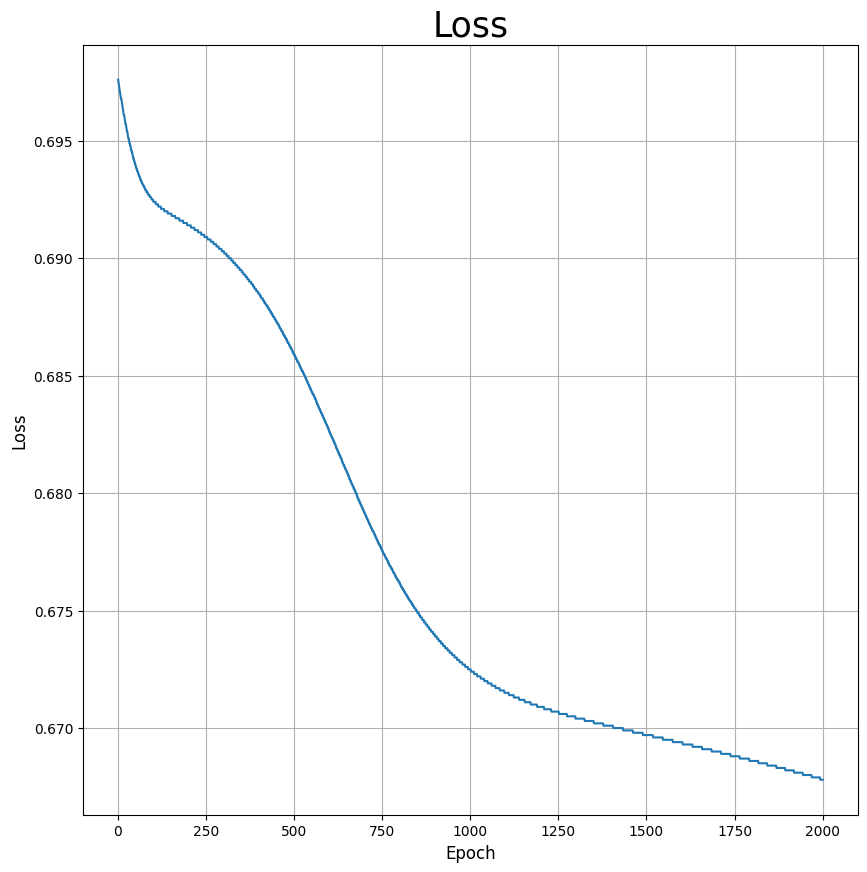

In [187]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()

In [189]:
t_X_test[5]

tensor([-0.1333, -1.3426, -0.1694, -0.4637, -0.3372, -0.3545, -0.1151, -0.2512,
         1.9658, -0.4910, -0.1521, -0.3078])

In [199]:
prediccion = model(t_X_test[5])
print(prediccion)

tensor([0.5056], grad_fn=<SigmoidBackward0>)


In [200]:
t_y_test[5]

tensor([0.])

# Red neuronal recurrente
Ahora crearemos la infraestructura de una RNR para el PLN y así poder realizar una comparación de accuracy